<a href="https://colab.research.google.com/github/envirodatascience/final-project-insect-team/blob/main/04_climate_insects_analyses_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook overview
Using the cleaned and summarized data from 03_ypm_insect_downloading_cleaning.ipynb and the climate data from xxxx.ipynb to plot and analyze relationships between insect species and climate patterns over time.

# Load modules

In [1]:
# General
import pandas as pd
import numpy as np

# Plotting
from plotnine import *
import plotnine
from mizani.formatters import scientific_format, percent_format, currency_format

# Stats
import statsmodels.api as sm
import scipy.stats as stats

## Subset dataset to CT only and the most interesting orders for joining to climate data

In [3]:
# read in data manually loaded into runtime files or frmo GitHub
# url = 'https://github.com/envirodatascience/final-project-insect-team/blob/main/ypm_ent_taxo_summaries_20250424.csv
ent = pd.read_csv('ypm_ent_taxo_summaries_20250424.csv')
ent.head()

,year,stateProvince,total_n_species,total_abundance,Lepidoptera_n_species,Lepidoptera_abundance,Hymenoptera_n_species,Hymenoptera_abundance,Coleoptera_n_species,Coleoptera_abundance,...,Poduromorpha_n_species,Poduromorpha_abundance,Nymphalidae_n_species,Nymphalidae_abundance,Apidae_n_species,Apidae_abundance,Noctuidae_n_species,Noctuidae_abundance,Papilionidae_n_species,Papilionidae_abundance
0,1901,Alaska,1,1,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1901,Arizona,1,1,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1901,California,4,6,1.0,2.0,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901,Colorado,2,3,1.0,1.0,NaN,NaN,1.0,2.0,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1901,Connecticut,7,7,6.0,6.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# subset to CT
ent_ct = ent[ent.stateProvince == 'Connecticut']
ent_ct.value_counts('stateProvince') # good

,count
stateProvince,
Connecticut,124


In [5]:
# select just a few orders of interest
ent_ct_sub = ent_ct[['year', 'stateProvince', 'total_n_species', 'Nymphalidae_n_species', 'Apidae_n_species', 'Noctuidae_n_species', 'Lepidoptera_n_species', 'Papilionidae_n_species', 'Coleoptera_n_species']]
ent_ct_sub.head()

,year,stateProvince,total_n_species,Nymphalidae_n_species,Apidae_n_species,Noctuidae_n_species,Lepidoptera_n_species,Papilionidae_n_species,Coleoptera_n_species
4,1901,Connecticut,7,NaN,NaN,NaN,6.0,NaN,1.0
30,1902,Connecticut,7,NaN,1.0,NaN,1.0,1.0,1.0
53,1903,Connecticut,9,NaN,NaN,NaN,5.0,NaN,NaN
74,1904,Connecticut,45,NaN,5.0,NaN,4.0,NaN,NaN
99,1905,Connecticut,30,NaN,5.0,NaN,8.0,NaN,1.0


In [6]:
# save subsetted file
ent_ct_sub.to_csv('ypm_ct_ent_taxo_summaries_20250424.csv', index=False)

## Merge datasets
Merge temp, precip, and insect datasets for CT

### Read in datasets

In [6]:
# read in precip data
# url = 'https://github.com/envirodatascience/final-project-insect-team/blob/main/noaa_precip_yearly_ct.csv'
df_pr = pd.read_csv('noaa_precip_yearly_ct.csv')
df_pr.head()

,DATE,PAVG,PMIN,PMAX
0,1858,41.89,41.89,41.89
1,1859,53.31,53.31,53.31
2,1860,37.38,37.38,37.38
3,1861,47.03,47.03,47.03
4,1862,48.02,48.02,48.02


In [8]:
# read in temp data
# url = 'https://github.com/envirodatascience/final-project-insect-team/blob/main/noaa_temp_yearly_ct.csv'
df_t = pd.read_csv('noaa_temp_yearly_ct.csv')
df_t.head()

,DATE,TMIN,TAVG,TMAX
0,1900,40.883333,51.050000,60.814286
1,1901,39.242857,49.040000,58.583333
2,1902,39.600000,49.420000,59.540000
3,1903,38.928571,48.785714,58.657143
4,1904,35.600000,46.025000,56.228571


In [10]:
# read in CT ent data
df_e = pd.read_csv('ypm_ct_ent_taxo_summaries_20250424.csv')
df_e.head()

,year,stateProvince,total_n_species,Nymphalidae_n_species,Apidae_n_species,Noctuidae_n_species,Lepidoptera_n_species,Papilionidae_n_species,Coleoptera_n_species
0,1901,Connecticut,7,NaN,NaN,NaN,6.0,NaN,1.0
1,1902,Connecticut,7,NaN,1.0,NaN,1.0,1.0,1.0
2,1903,Connecticut,9,NaN,NaN,NaN,5.0,NaN,NaN
3,1904,Connecticut,45,NaN,5.0,NaN,4.0,NaN,NaN
4,1905,Connecticut,30,NaN,5.0,NaN,8.0,NaN,1.0


In [11]:
df_e.rename(columns={'year': 'DATE'}, inplace=True)
df_e.head()

,DATE,stateProvince,total_n_species,Nymphalidae_n_species,Apidae_n_species,Noctuidae_n_species,Lepidoptera_n_species,Papilionidae_n_species,Coleoptera_n_species
0,1901,Connecticut,7,NaN,NaN,NaN,6.0,NaN,1.0
1,1902,Connecticut,7,NaN,1.0,NaN,1.0,1.0,1.0
2,1903,Connecticut,9,NaN,NaN,NaN,5.0,NaN,NaN
3,1904,Connecticut,45,NaN,5.0,NaN,4.0,NaN,NaN
4,1905,Connecticut,30,NaN,5.0,NaN,8.0,NaN,1.0


### Merge

In [12]:
# merge temp and precip
df_tp = df_t.merge(df_pr,how='outer', on='DATE')
df_tp.tail()

,DATE,TMIN,TAVG,TMAX,PAVG,PMIN,PMAX
162,2021,42.278571,51.507143,60.721429,53.334416,38.43,66.84
163,2022,40.656250,50.962500,61.305882,46.398205,34.26,57.14
164,2023,42.686667,52.173333,61.660000,62.344521,46.20,73.91
165,2024,42.162500,51.956250,61.762500,54.480676,41.60,66.27
166,2025,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# merge ent data on to climate data
df_all = df_tp.merge(df_e,how='inner', on='DATE')
df_all.head()

,DATE,TMIN,TAVG,TMAX,PAVG,PMIN,PMAX,stateProvince,total_n_species,Nymphalidae_n_species,Apidae_n_species,Noctuidae_n_species,Lepidoptera_n_species,Papilionidae_n_species,Coleoptera_n_species
0,1901,39.242857,49.040000,58.583333,59.651111,38.67,68.77,Connecticut,7,NaN,NaN,NaN,6.0,NaN,1.0
1,1902,39.600000,49.420000,59.540000,52.378571,34.96,61.85,Connecticut,7,NaN,1.0,NaN,1.0,1.0,1.0
2,1903,38.928571,48.785714,58.657143,49.262857,34.44,58.02,Connecticut,9,NaN,NaN,NaN,5.0,NaN,NaN
3,1904,35.600000,46.025000,56.228571,43.526250,38.05,48.22,Connecticut,45,NaN,5.0,NaN,4.0,NaN,NaN
4,1905,38.480000,48.740000,59.020000,41.735714,36.13,52.78,Connecticut,30,NaN,5.0,NaN,8.0,NaN,1.0


In [14]:
df_all.to_csv('CT_insect_climate_data.csv', index=False)

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


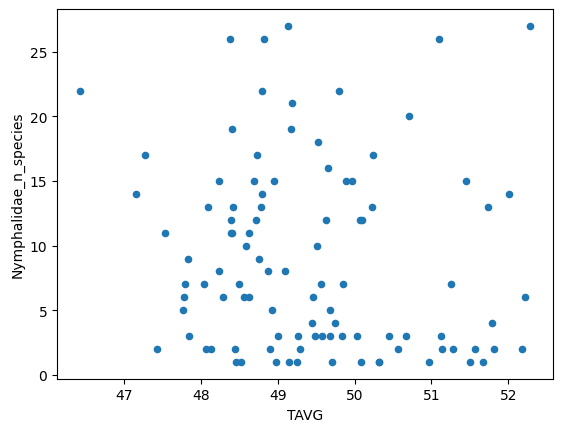

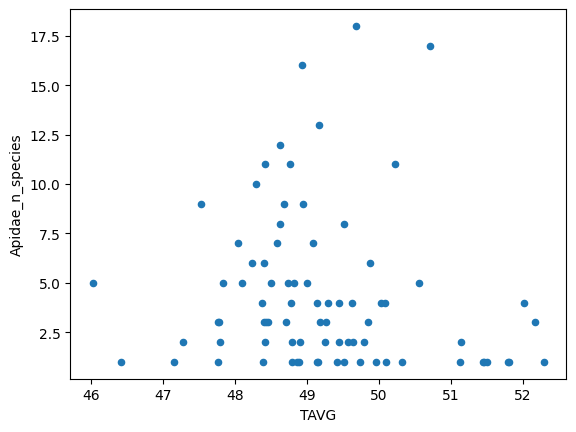

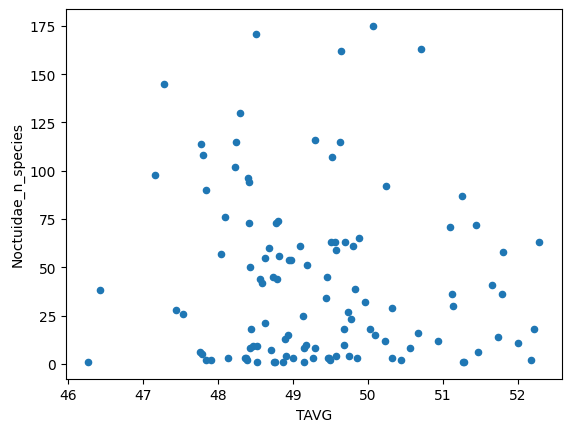

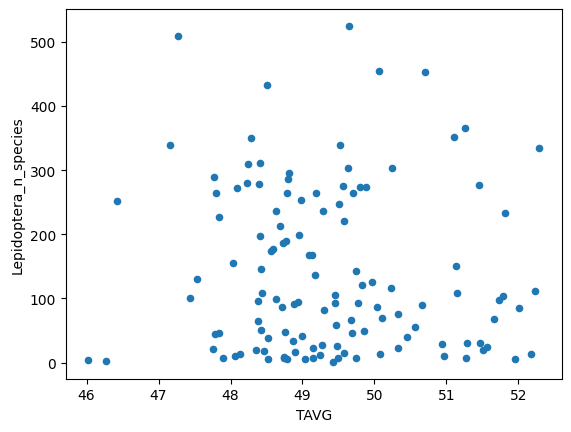

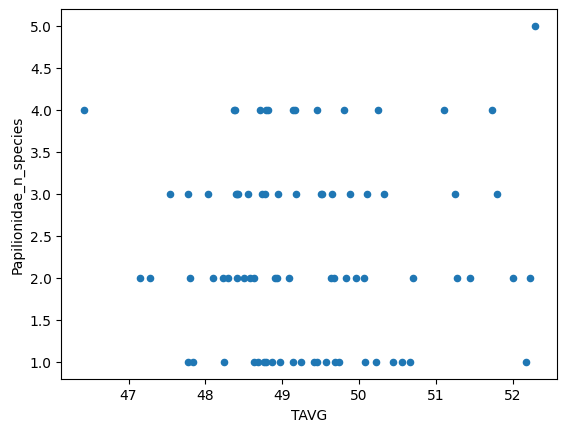

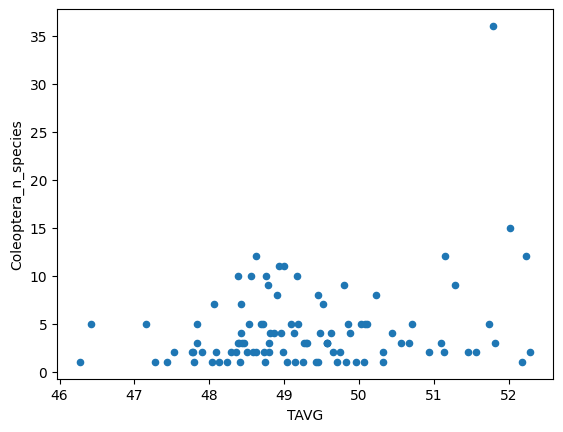

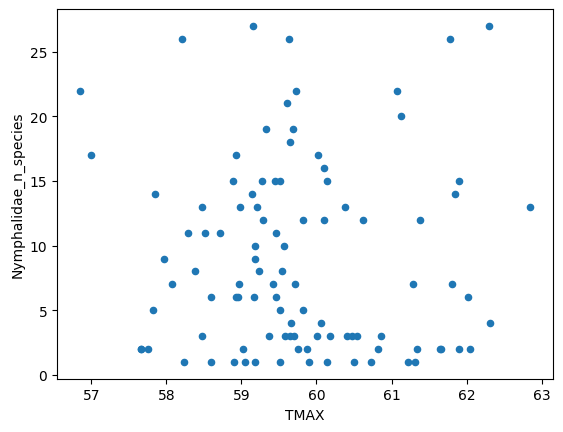

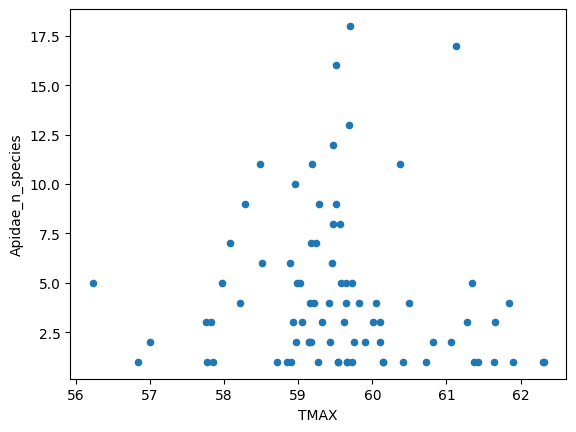

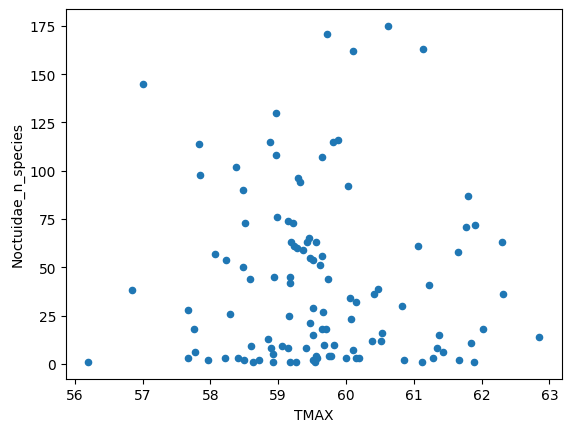

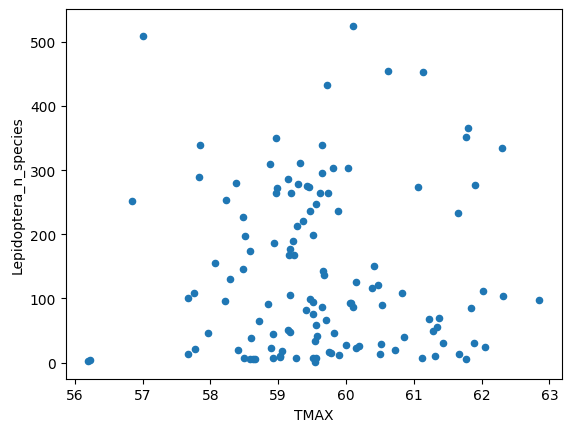

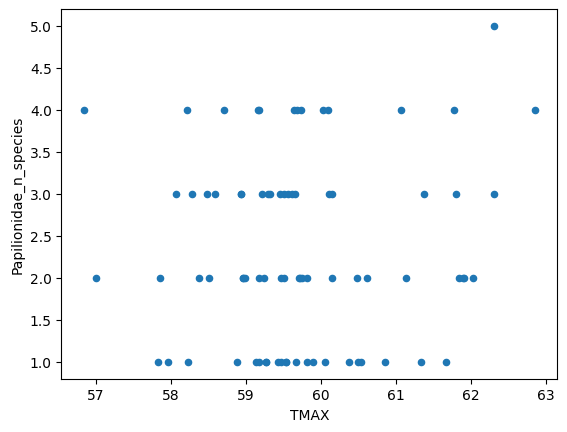

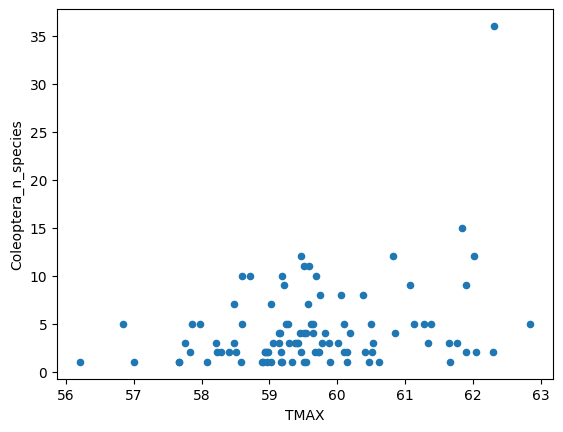

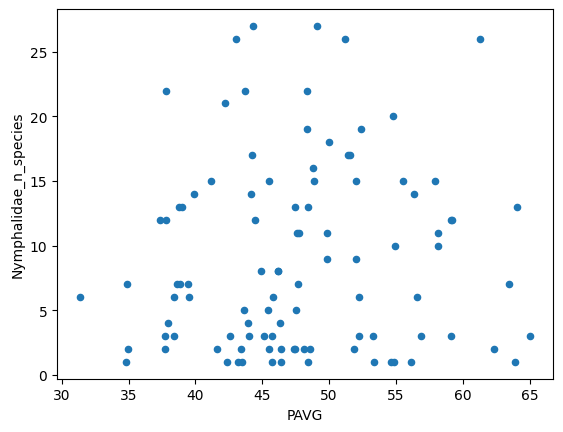

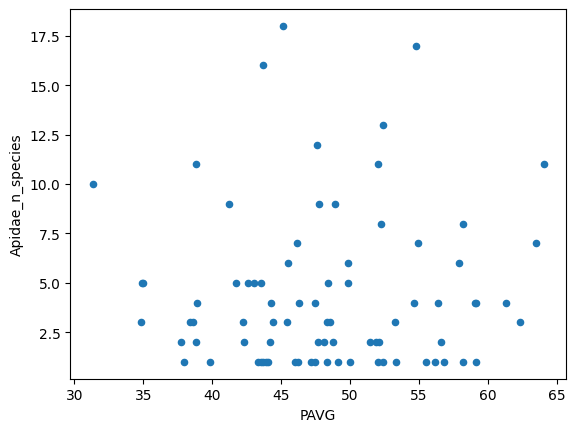

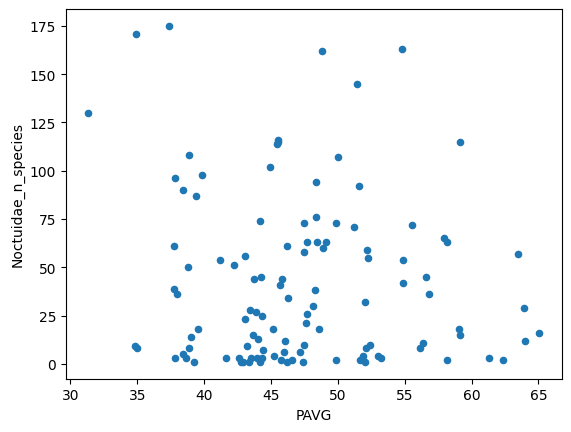

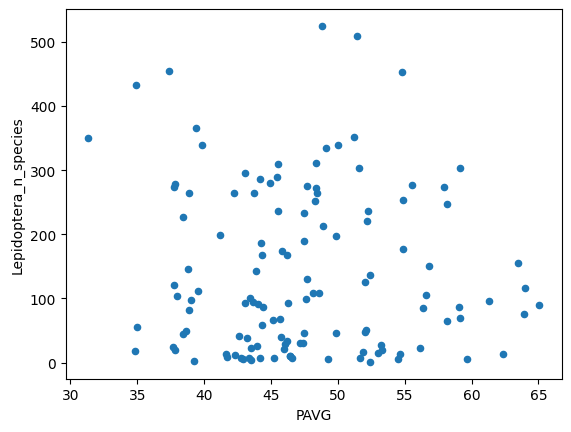

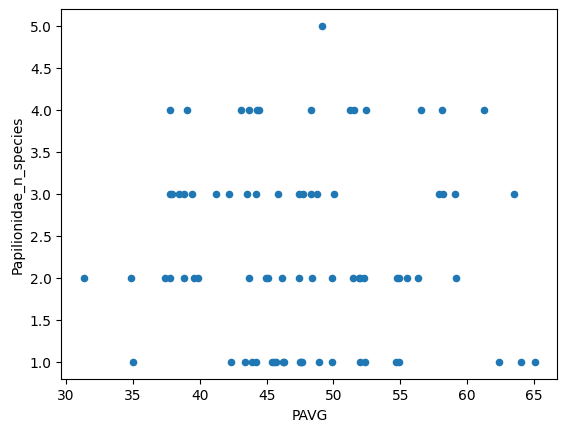

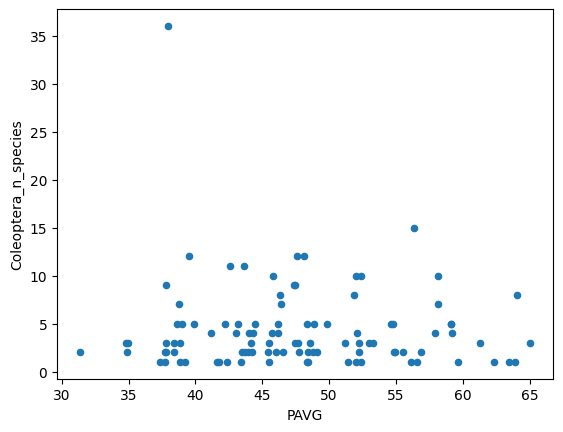

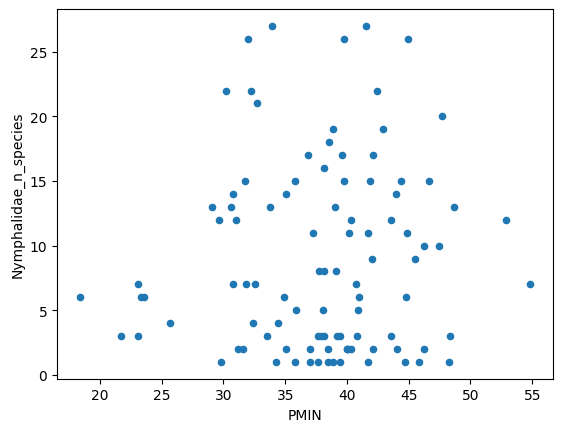

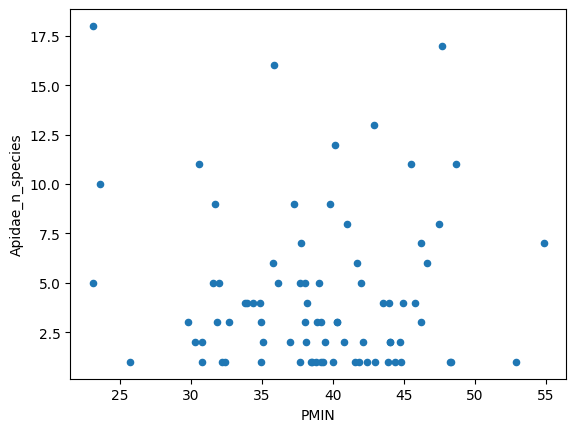

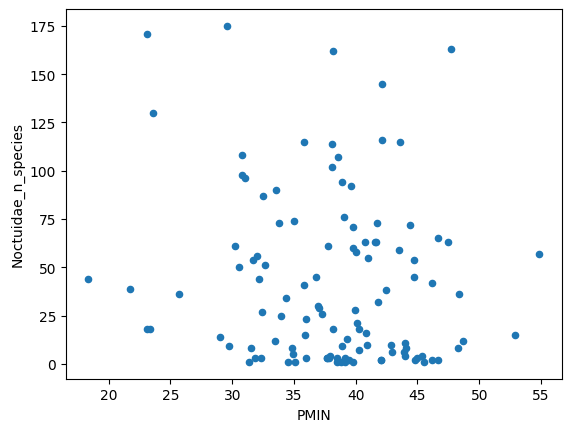

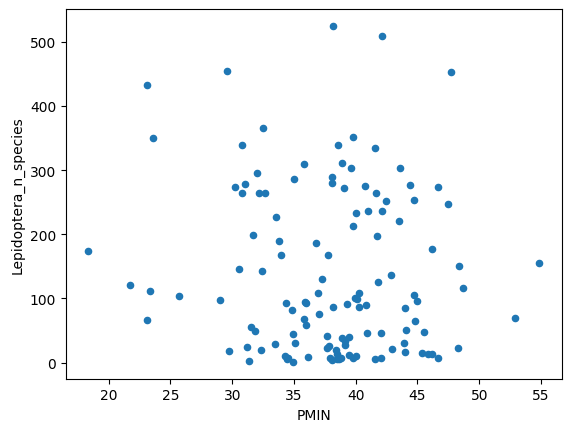

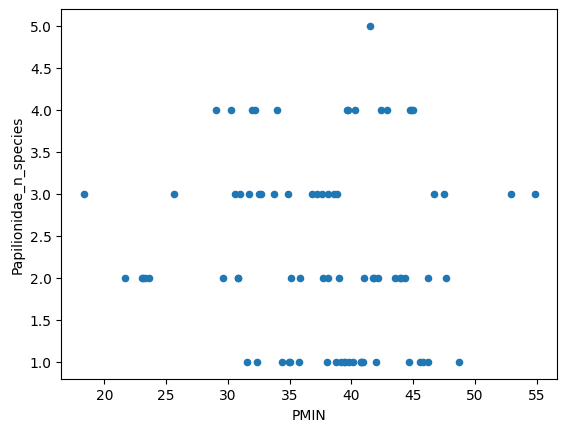

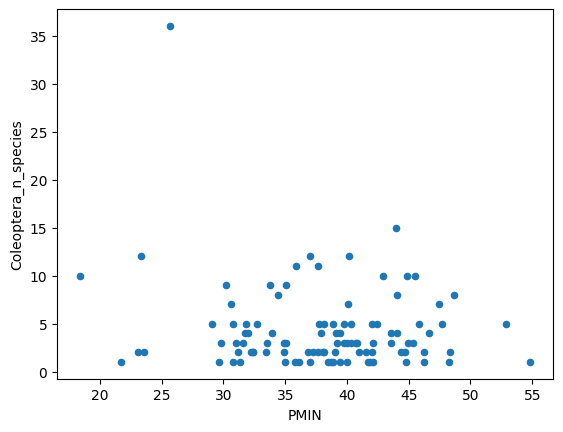

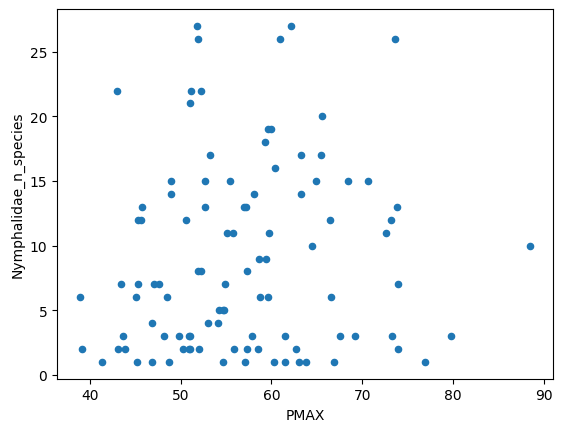

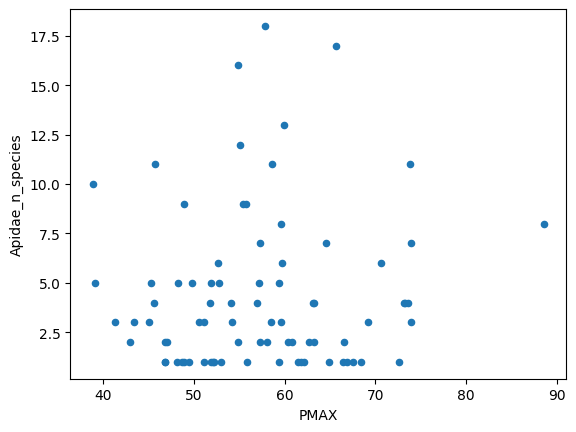

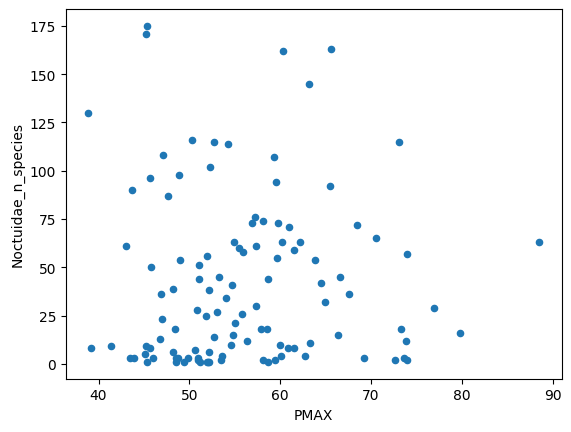

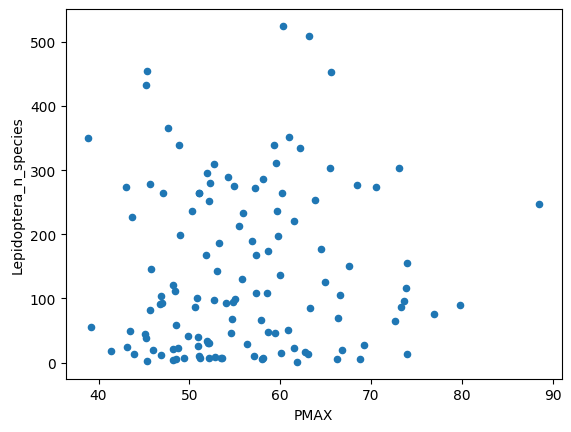

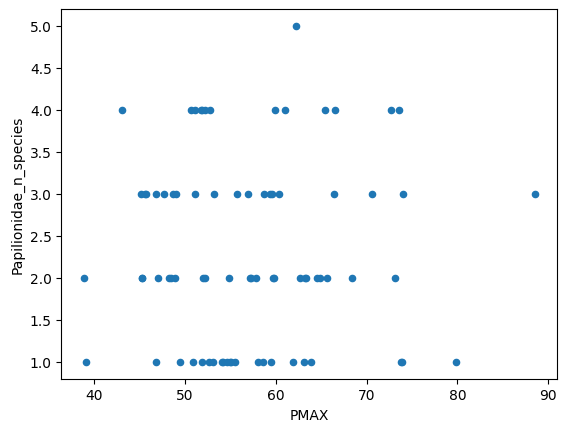

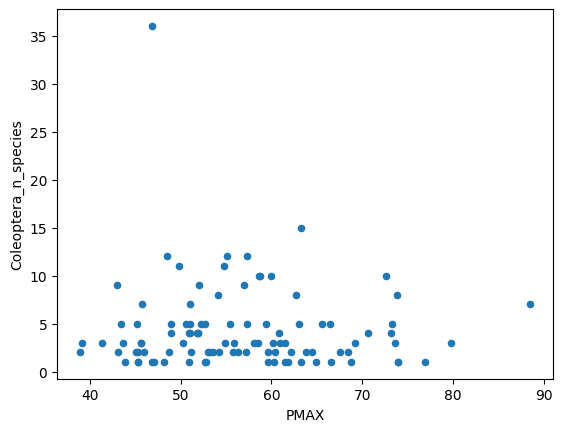

In [15]:
for i in df_all.columns[2:7]:
  for j in df_all.columns[9:15]:
    df_all.plot.scatter(i, j)

In the plots above, we see some trends between number of lepidoptera species per year and the climate variables, but the other taxa do not have clear patterns. Papillonidae does not seem to have enough data, likewise with Coleoptera with the exception of one datapoint.

In [ ]:
# want temp/precip NAs to stay NA, but insect NAs should be 0? maybe remove all NAs?
# or can we just skip rows with NAs? there's an option in r... i think

## Run linear regressions on data
Will try all possible combinations - write as a loop?

In [16]:
# first a simple one
model = sm.OLS(df_all.PMAX,df_all.total_n_species)
result = model.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.591    
Dependent Variable:     PMAX             AIC:                         1244.2017
Date:                   2025-04-25 20:23 BIC:                         1247.0220
No. Observations:       124              Log-Likelihood:              -621.10  
Df Model:               1                F-statistic:                 180.4    
Df Residuals:           123              Prob (F-statistic):          7.04e-26 
R-squared (uncentered): 0.595            Scale:                       1323.4   
----------------------------------------------------------------------------------
                       Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------------------
total_n_species        0.2054      0.0153    13.4330    0.0000    0.1751    0.2356
-------------------------------------------------------------------------------
Omnibus:                   8.685             Durbin-Watson:               0.369
Prob(Omnibus):             0.013             Jarque-Bera (JB):            9.299
Skew:                      -0.658            Prob(JB):                    0.010
Kurtosis:                  2.742             Condition No.:               1    
===============================================================================
Notes:
[1] R² is computed without centering (uncentered) since the
model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is
correctly specified.
"""

p
const    0.179935
PMAX     0.396994
dtype: float64
r2
0.005887160375903866


<Axes: xlabel='PMAX', ylabel='total_n_species'>

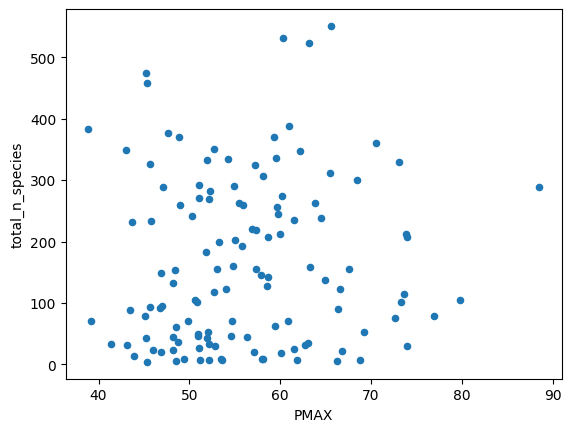

In [17]:
# test the code that gemini gave me below
x = df_all['PMAX']
y = df_all['total_n_species']
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

 # Extract p-value and R-squared
p_value = model.pvalues
r_squared = model.rsquared

print('p')
print(p_value)
print('r2')
print(r_squared)
df_all.plot.scatter('PMAX','total_n_species')

In [18]:
# loop through climate and response vars?
# have done this in R, hoping to replicate process in Python
# prompt: loop through columns 2:7 as independent variables and 9:15 as dependent vars and run linear regressions for each combination of variables, saving the p and R2 values from each regression in a dataframe

# Assuming df_all is your DataFrame as defined in the previous code.
results = []

# Loop through independent variables (columns 2-7)
for indep_var in df_all.columns[1:7]:  # Assuming the independent vars start from the second column
    # Loop through dependent variables (columns 9-15)
    for dep_var in df_all.columns[8:15]:
        # Fit the linear regression model
        x = df_all[indep_var]
        y = df_all[dep_var]

        # Add a constant to the independent variable (intercept term)
        x = sm.add_constant(x)

        model = sm.OLS(y, x, missing='drop').fit() # drop rows with NA values rather than making them 0 or removing earlier

        # Extract p-value and R-squared
        p_value = model.pvalues[indep_var]
        r_squared = model.rsquared

        # Store results
        results.append([indep_var, dep_var, p_value, r_squared])

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['Independent Variable', 'Dependent Variable', 'P-value', 'R-squared'])

results_df

,Independent Variable,Dependent Variable,P-value,R-squared
0,TMIN,total_n_species,0.133773,0.018333
1,TMIN,Nymphalidae_n_species,0.070231,0.033057
2,TMIN,Apidae_n_species,0.302107,0.013646
3,TMIN,Noctuidae_n_species,0.109077,0.023175
4,TMIN,Lepidoptera_n_species,0.180924,0.014624
5,TMIN,Papilionidae_n_species,0.815405,0.000722
6,TMIN,Coleoptera_n_species,0.052552,0.037810
7,TAVG,total_n_species,0.392868,0.005991
8,TAVG,Nymphalidae_n_species,0.191803,0.017322
9,TAVG,Apidae_n_species,0.260918,0.016175


In [19]:
# check for anything marginally significant
results_df[results_df['P-value'] < 0.1]

,Independent Variable,Dependent Variable,P-value,R-squared
1,TMIN,Nymphalidae_n_species,0.070231,0.033057
6,TMIN,Coleoptera_n_species,0.052552,0.037810
13,TAVG,Coleoptera_n_species,0.008506,0.068547
20,TMAX,Coleoptera_n_species,0.001675,0.096323


a few significant relationships:
* tmin vs nymphalidae n species (p < 0.1)
* tmin vs coleoptera n species (p < 0.1)
* tmax vs coleoptera n species (p < 0.05)
* tavg vs coleoptera n species (p < 0.05)

Nothing for precipitation, nothing for our most abundant taxonomic groups.

Even for these 'significant' taxa, the r2 values are poor.

In [20]:
# save statistics results
# consider running again with only up to 2000 - but then lose some of the climate nuance

results_df.to_csv('insect_climate_regression_stats_20250425.csv', index=False)

## Make nice plots for presentation
* temp vs year
* precip vs year
* temp vs precip
* temp vs n species (whichever are sig.)
  * coleoptera vs tmax, nymphalidae vs tmin, , coleoptera tmax, coleoptera tavg
* precip vs n species (whichever are sig.)
  * none
* insect data vs year and/or hist of insect data

In [28]:
df_all.columns

Index(['DATE', 'TMIN', 'TAVG', 'TMAX', 'PAVG', 'PMIN', 'PMAX', 'stateProvince',
       'total_n_species', 'Nymphalidae_n_species', 'Apidae_n_species',
       'Noctuidae_n_species', 'Lepidoptera_n_species',
       'Papilionidae_n_species', 'Coleoptera_n_species'],
      dtype='object')

### Temperature vs year

In [29]:
# format to have date, temp, temp val cols
df_temp = df_all.melt(id_vars = 'DATE', value_vars=['TMIN', 'TMAX', 'TAVG'])
df_temp.head()

,DATE,variable,value
0,1901,TMIN,39.242857
1,1902,TMIN,39.600000
2,1903,TMIN,38.928571
3,1904,TMIN,35.600000
4,1905,TMIN,38.480000


In [44]:
# temp vs year
p = (
  ggplot(df_temp, aes(x='DATE', y='value', color = 'variable'))
    + geom_point()
    + geom_smooth(method='lm', color='gray')
    + xlab("Year")
    + ylab("Temperature (C)")
    + labs(color='Variable')
    + theme_classic()
    + theme(axis_line=element_line(color="gray"),
            axis_ticks=element_line(color = "gray"),
            text=element_text(size = 12),
            legend_position="right")
    + scale_colour_manual(values=['#eba13b', '#eb4c3b', '#91bfdb'])
)

ggsave(p, 'temp_year.png')


/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: temp_year.png


### Precip vs year

In [45]:
# format to have date, prec, prec val cols
df_prcp = df_all.melt(id_vars = 'DATE', value_vars=['PMIN', 'PMAX', 'PAVG'])
df_prcp.head()

,DATE,variable,value
0,1901,PMIN,38.67
1,1902,PMIN,34.96
2,1903,PMIN,34.44
3,1904,PMIN,38.05
4,1905,PMIN,36.13


In [48]:
# prec vs year
p = (
  ggplot(df_prcp, aes(x='DATE', y='value', color = 'variable'))
    + geom_point()
    + geom_smooth(method='lm', color='gray')
    + xlab("Year")
    + ylab("Precipitation (mm)")
    + labs(color='Variable')
    + theme_classic()
    + theme(axis_line=element_line(color="gray"),
            axis_ticks=element_line(color = "gray"),
            text=element_text(size = 12),
            legend_position="right")
    + scale_colour_manual(values=['#3bb6eb', '#413beb', '#a73beb'])
)
p
ggsave(p, 'prcp_year.png')

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: prcp_year.png


### Insect data vs year

In [49]:
df_all.columns

Index(['DATE', 'TMIN', 'TAVG', 'TMAX', 'PAVG', 'PMIN', 'PMAX', 'stateProvince',
       'total_n_species', 'Nymphalidae_n_species', 'Apidae_n_species',
       'Noctuidae_n_species', 'Lepidoptera_n_species',
       'Papilionidae_n_species', 'Coleoptera_n_species'],
      dtype='object')

In [57]:
# format to have date, n species, n species val cols
df_ent = df_all.melt(id_vars = 'DATE', value_vars=['total_n_species', 'Lepidoptera_n_species', 'Coleoptera_n_species', 'Apidae_n_species'])
df_ent.head()

,DATE,variable,value
0,1901,total_n_species,7.0
1,1902,total_n_species,7.0
2,1903,total_n_species,9.0
3,1904,total_n_species,45.0
4,1905,total_n_species,30.0


In [59]:
# insect n species vs year
p = (
  ggplot(df_ent, aes(x='DATE', y='value', color = 'variable'))
    + geom_point()
    + xlab("Year")
    + ylab("Number of Species")
    + labs(color='Variable')
    + theme_classic()
    + theme(axis_line=element_line(color="gray"),
            axis_ticks=element_line(color = "gray"),
            text=element_text(size = 12),
            legend_position="right")
    # + scale_colour_manual(values=['#3bb6eb', '#413beb', '#a73beb'])
)
p
ggsave(p, 'ent_groups_year.png')

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ent_groups_year.png
/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 68 rows containing missing values.


In [56]:
p = (
  ggplot(df_all, aes(x='DATE', y='total_n_species'))
    + geom_point()
    # + geom_smooth(method='lm', color='gray')
    + xlab("Year")
    + ylab("Number of Species")
    + labs(color='Variable')
    + theme_classic()
    + theme(axis_line=element_line(color="gray"),
            axis_ticks=element_line(color = "gray"),
            text=element_text(size = 12),
            legend_position="right")
)
p
ggsave(p, 'total_n_species_year.png')

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: total_n_species_year.png


### Temperature vs precipitation

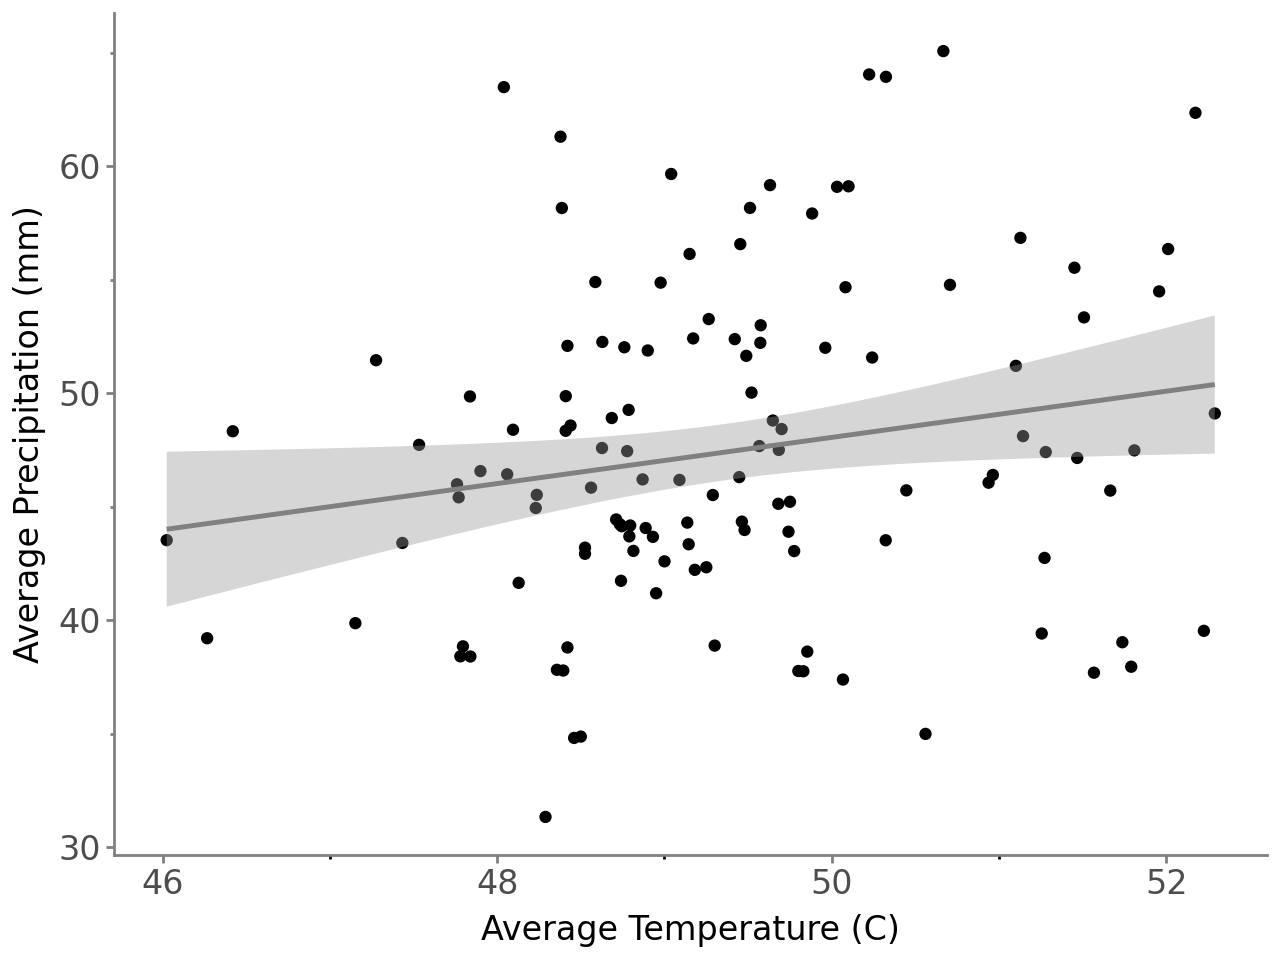

In [61]:
p = (
  ggplot(df_all, aes(x='TAVG', y='PAVG'))
    + geom_point()
    + geom_smooth(method='lm', color='gray')
    + xlab("Average Temperature (C)")
    + ylab("Average Precipitation (mm)")
    + labs(color='Variable')
    + theme_classic()
    + theme(axis_line=element_line(color="gray"),
            axis_ticks=element_line(color = "gray"),
            text=element_text(size = 12),
            legend_position="right")
)
p
# this doesn't show anything, not saving

### Insects vs temperature (significant)

In [64]:
# coleoptera vs tmax
p = (
  ggplot(df_all, aes(x='TMAX', y='Coleoptera_n_species'))
    + geom_point()
    + geom_smooth(method='lm', color='gray')
    + xlab("Maximum Temperature (C)")
    + ylab("Number of Beetle Species")
    + labs(color='Variable')
    + theme_classic()
    + theme(axis_line=element_line(color="gray"),
            axis_ticks=element_line(color = "gray"),
            text=element_text(size = 12),
            legend_position="right")
)
p

ggsave(p, 'coleoptera_tmax.png')

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: coleoptera_tmax.png
/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 24 rows containing missing values.


In [69]:
# coleoptera tmin
p = (
  ggplot(df_all, aes(x='TMIN', y='Coleoptera_n_species'))
    + geom_point()
    + geom_smooth(method='lm', color='gray')
    + xlab("Minimum Temperature (C)")
    + ylab("Number of Beetle Species")
    + labs(color='Variable')
    + theme_classic()
    + theme(axis_line=element_line(color="gray"),
            axis_ticks=element_line(color = "gray"),
            text=element_text(size = 12),
            legend_position="right")
)
p

ggsave(p, 'coleoptera_tmin.png')

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: coleoptera_tmin.png
/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 24 rows containing missing values.


In [68]:
# coleoptera tavg
p = (
  ggplot(df_all, aes(x='TAVG', y='Coleoptera_n_species'))
    + geom_point()
    + geom_smooth(method='lm', color='gray')
    + xlab("Average Temperature (C)")
    + ylab("Number of Beetle Species")
    + labs(color='Variable')
    + theme_classic()
    + theme(axis_line=element_line(color="gray"),
            axis_ticks=element_line(color = "gray"),
            text=element_text(size = 12),
            legend_position="right")
)
p

ggsave(p, 'coleoptera_tavg.png')

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: coleoptera_tavg.png
/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 24 rows containing missing values.


In [67]:
# nymphalidae vs tmin
p = (
  ggplot(df_all, aes(x='TMIN', y='Nymphalidae_n_species'))
    + geom_point()
    + geom_smooth(method='lm', color='gray')
    + xlab("Minimum Temperature (C)")
    + ylab("Number of Nymphalidae Species")
    + labs(color='Variable')
    + theme_classic()
    + theme(axis_line=element_line(color="gray"),
            axis_ticks=element_line(color = "gray"),
            text=element_text(size = 12),
            legend_position="right")
)
p

ggsave(p, 'nymphalidae_tmin.png')

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: nymphalidae_tmin.png
/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 24 rows containing missing values.
